# Filter Intact Interactions for Desired Interaction Set

In [1]:
import os
import pickle as pk
import gc

import re
import networkx as nx
from scipy import sparse, linalg
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
top_dir = '../'
inp_dir = os.path.join(top_dir, 'data/raw/intact')
os.listdir(inp_dir)

['intact.txt',
 'Cancer.zip',
 'intact_negative.txt',
 'psimitab',
 'README.md',
 'intact_homo_sapiens.txt',
 'intact.zip',
 'Cancer']

In [3]:
output_dir = os.path.join(top_dir, 'data/preproc/intact_proc')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## Load Interactions

In [4]:
intact_file = os.path.join(inp_dir, 'intact.txt')
intact_df = pd.read_table(intact_file, sep='\t')

In [5]:
intact_df.shape

(1572112, 42)

In [6]:
intact_df.head()

,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Checksum(s) interactor A,Checksum(s) interactor B,Interaction Checksum(s),Negative,Feature(s) interactor A,Feature(s) interactor B,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B
0,uniprotkb:O43426,uniprotkb:P49418,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:F4234557A3B54840|rigid:n+UcEH4PPLkF...,False,binding-associated region:1063-1070(MINT-376288),binding-associated region:626-695(MINT-376295),-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific..."
1,intact:EBI-7121639,uniprotkb:P49418,intact:MINT-8094608,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:vrparrvlw(display_short)|psi-mi:EBI-712...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...",...,rogid:lPy6gBhpgvyGSYgOqeHbjcqBtMQ-2,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:880913D9000BF26E|rigid:iRObbQsaUeX0...,False,-,binding-associated region:626-695(MINT-8094602),-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0078""(nucleotide sequence identific..."
2,intact:EBI-7121654,uniprotkb:P49418,intact:MINT-8094645,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:hrpvrraap(display_short)|psi-mi:EBI-712...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...",...,rogid:GsDnsVmAo8ZZoKTZ4/uDb2x+h3c-2,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:B68245E1F0508124|rigid:SlinPP5vIczF...,False,-,binding-associated region:626-695(MINT-8094630),-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0078""(nucleotide sequence identific..."
3,intact:EBI-7121715,uniprotkb:P49418,intact:MINT-8094663,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:vrptraada(display_short)|psi-mi:EBI-712...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...",...,rogid:M+f6GE3SQXrMBiIVttW1MKhz3M0-2,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:8F7F46DF027DF34E|rigid:uiWbDe6gaj1X...,False,-,binding-associated region:626-695(MINT-8094654),-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0078""(nucleotide sequence identific..."
4,uniprotkb:P49418,intact:EBI-7121765,intact:EBI-7121510|intact:MINT-109264|uniprotk...,intact:MINT-8094691,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:xrprrghal(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:cilZXZ3YLDI1s7n8WNRyUE6EnJQ-2,intact-crc:2EF43A66D9B2D428|rigid:/ki1zA46M4Q+...,False,binding-associated region:626-695(MINT-8094680),-,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)"


In [7]:
intact_df.columns

Index(['#ID(s) interactor A', 'ID(s) interactor B', 'Alt. ID(s) interactor A',
       'Alt. ID(s) interactor B', 'Alias(es) interactor A',
       'Alias(es) interactor B', 'Interaction detection method(s)',
       'Publication 1st author(s)', 'Publication Identifier(s)',
       'Taxid interactor A', 'Taxid interactor B', 'Interaction type(s)',
       'Source database(s)', 'Interaction identifier(s)',
       'Confidence value(s)', 'Expansion method(s)',
       'Biological role(s) interactor A', 'Biological role(s) interactor B',
       'Experimental role(s) interactor A',
       'Experimental role(s) interactor B', 'Type(s) interactor A',
       'Type(s) interactor B', 'Xref(s) interactor A', 'Xref(s) interactor B',
       'Interaction Xref(s)', 'Annotation(s) interactor A',
       'Annotation(s) interactor B', 'Interaction annotation(s)',
       'Host organism(s)', 'Interaction parameter(s)', 'Creation date',
       'Update date', 'Checksum(s) interactor A', 'Checksum(s) interactor B',

In [8]:
idx_a = intact_df['Taxid interactor A'].str.contains('9606\(Homo sapiens\)')
idx_b = intact_df['Taxid interactor B'].str.contains('9606\(Homo sapiens\)')

In [9]:
intact_df_homo_sapiens = intact_df.iloc[np.logical_and(idx_a.values, idx_b.values), :]
intact_df_homo_sapiens.head()

,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Checksum(s) interactor A,Checksum(s) interactor B,Interaction Checksum(s),Negative,Feature(s) interactor A,Feature(s) interactor B,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B
0,uniprotkb:O43426,uniprotkb:P49418,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:F4234557A3B54840|rigid:n+UcEH4PPLkF...,False,binding-associated region:1063-1070(MINT-376288),binding-associated region:626-695(MINT-376295),-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific..."
28,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|intact:MINT-109264|uniprotk...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,intact-crc:1B3C495D257C1999|rigid:n+UcEH4PPLkF...,False,glutathione s tranferase tag:?-?(MINT-8095915)...,binding-associated region:1060-1076(MINT-8095871),-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)"
29,uniprotkb:O43426,uniprotkb:P49418,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,intact:EBI-7121510|intact:MINT-109264|uniprotk...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:3B294E9363BBEBF0|rigid:n+UcEH4PPLkF...,False,binding-associated region:1191-1206(MINT-8095927),binding-associated region:620-695(MINT-8095931...,-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0411""(enzyme linked immunosorbent a..."
30,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|intact:MINT-109264|uniprotk...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,intact-crc:17D53C44727F66B6|rigid:n+UcEH4PPLkF...,False,binding-associated region:620-695(MINT-8095970...,binding-associated region:1280-1295(MINT-8095964),-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)"
31,uniprotkb:O43426,uniprotkb:Q99961,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,intact:EBI-697911|uniprotkb:M0QZV5|uniprotkb:Q...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,rogid:Qzz+R0MGXEpZ6G0xoPglUBKBIfk9606,intact-crc:0308D6DE536C0DF4|rigid:fxkuzNe+wQW8...,False,binding-associated region:1060-1076(MINT-8096050),glutathione s tranferase tag:?-?(MINT-8096039)...,-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:041

In [10]:
intact_df_homo_sapiens.shape

(922560, 42)

In [11]:
def extract_gene_name(x):
    match = re.search("(?<=uniprotkb:)[A-Z0-9]+(?=\(gene name\))", x)
    # return match
    # print(match)
    if match:
        result = match.group(0)
    else:
        result = ""
    return result

In [12]:
interactor_A_aliases = intact_df_homo_sapiens['Alias(es) interactor A'].values
interactor_A_gene = [extract_gene_name(x) for x in interactor_A_aliases]
interactor_B_aliases = intact_df_homo_sapiens['Alias(es) interactor B'].values
interactor_B_gene = [extract_gene_name(x) for x in interactor_B_aliases]

In [13]:
interactor_A_aliases

array(['psi-mi:synj1_human(display_long)|uniprotkb:SYNJ1(gene name)|psi-mi:SYNJ1(display_short)|uniprotkb:KIAA0910(gene name synonym)|uniprotkb:Synaptic inositol 1,4,5-trisphosphate 5-phosphatase 1(gene name synonym)',
       'psi-mi:amph_human(display_long)|uniprotkb:AMPH(gene name)|psi-mi:AMPH(display_short)|uniprotkb:AMPH1(gene name synonym)',
       'psi-mi:synj1_human(display_long)|uniprotkb:SYNJ1(gene name)|psi-mi:SYNJ1(display_short)|uniprotkb:KIAA0910(gene name synonym)|uniprotkb:Synaptic inositol 1,4,5-trisphosphate 5-phosphatase 1(gene name synonym)',
       ...,
       'psi-mi:klk10_human(display_long)|uniprotkb:Protease serine-like 1(gene name synonym)|uniprotkb:Normal epithelial cell-specific 1(gene name synonym)|uniprotkb:KLK10(gene name)|psi-mi:KLK10(display_short)|uniprotkb:NES1(gene name synonym)|uniprotkb:PRSSL1(gene name synonym)',
       'psi-mi:hsa-mir-142-5p(display_short)|psi-mi:EBI-25682788(display_long)',
       'psi-mi:hsa-mir-106b-5p(display_short)|psi-mi:EBI

In [14]:
intact_df_homo_sapiens['gene_A'] = interactor_A_gene
intact_df_homo_sapiens['gene_B'] = interactor_B_gene

/home/whitleyo/miniforge3/envs/pytorch3drugcell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/whitleyo/miniforge3/envs/pytorch3drugcell/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# del idx_A
# del idx_B
idx_A = np.logical_not(intact_df_homo_sapiens['gene_A'].values == '')
idx_B = np.logical_not(intact_df_homo_sapiens['gene_B'].values == '')
intact_df_homo_sapiens = intact_df_homo_sapiens.iloc[np.logical_and(idx_A, idx_B), :]

In [16]:
# let's subset for physical association or direct interaction
intact_df_homo_sapiens['Interaction type(s)'].value_counts()

psi-mi:"MI:0914"(association)                                           442863
psi-mi:"MI:0915"(physical association)                                  327728
psi-mi:"MI:2364"(proximity)                                              51084
psi-mi:"MI:0407"(direct interaction)                                     15959
psi-mi:"MI:0403"(colocalization)                                          3803
psi-mi:"MI:0217"(phosphorylation reaction)                                1937
psi-mi:"MI:0220"(ubiquitination reaction)                                  401
psi-mi:"MI:0203"(dephosphorylation reaction)                               362
psi-mi:"MI:0570"(protein cleavage)                                         228
psi-mi:"MI:0194"(cleavage reaction)                                        160
psi-mi:"MI:0213"(methylation reaction)                                      73
psi-mi:"MI:0557"(adp ribosylation reaction)                                 58
psi-mi:"MI:0414"(enzymatic reaction)                

In [17]:
accepted_interaction_types = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0407"(direct interaction)']
intact_df_homo_sapiens = intact_df_homo_sapiens.iloc[np.in1d(intact_df_homo_sapiens['Interaction type(s)'].values, accepted_interaction_types), :]

In [18]:
intact_df_homo_sapiens['Interaction type(s)'].value_counts()

psi-mi:"MI:0915"(physical association)    327728
psi-mi:"MI:0407"(direct interaction)       15959
Name: Interaction type(s), dtype: int64

## Convert to Interaction Matrix

In [19]:
np.sum(intact_df_homo_sapiens.loc[:, ['gene_A', 'gene_B']].duplicated())

166305

In [20]:
intact_df_homo_sapiens.loc[:, ['gene_A', 'gene_B']]

,gene_A,gene_B
0,SYNJ1,AMPH
28,AMPH,SYNJ1
29,SYNJ1,AMPH
30,AMPH,SYNJ1
31,SYNJ1,SH3GL1
...,...,...
1554581,CIB1,STMN2
1554582,STMN2,CIB1
1572085,RELA,MIR338
1572089,CLDN2,SQSTM1


In [21]:
dup_idx = intact_df_homo_sapiens.loc[:, ['gene_A', 'gene_B']].duplicated().values
sum(dup_idx)

166305

In [22]:
# remove 166k duplicate interactions
intact_df_homo_sapiens = intact_df_homo_sapiens.iloc[np.logical_not(dup_idx), :]
intact_df_homo_sapiens.shape

(177382, 44)

In [23]:
# 16k interactors
len(np.unique(np.concatenate([intact_df_homo_sapiens['gene_A'].values, intact_df_homo_sapiens['gene_B'].values], axis = 0).astype('str')))

16015

In [24]:
G = nx.Graph()
for i in range(intact_df_homo_sapiens.shape[0]):
    G.add_edge(intact_df_homo_sapiens['gene_A'].values[i], intact_df_homo_sapiens['gene_B'].values[i])

In [25]:
A = nx.adjacency_matrix(G).todense()

In [26]:
np.quantile(A.flatten(), [0, 0.25, 0.5, 0.75, 1.0])

array([0., 0., 0., 0., 1.])

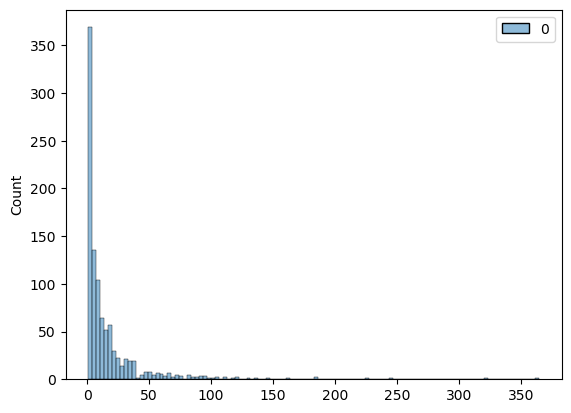

In [27]:
# show histogram of number of interactors
rand_idx = np.random.choice(np.arange(A.shape[0]), size=1000, replace=False)
sns.histplot(A.sum(axis=1)[rand_idx])

In [28]:
A_df = pd.DataFrame(A, index=list(G.nodes()), columns=list(G.nodes()))

## Save Results

In [29]:
out_file = os.path.join(output_dir, 'A.csv')
A_df.to_csv(out_file, index=True)